The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.ions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [5]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set environment settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Now we will load our datasets and the data dictionary file.
The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 
So, for model selection, We will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [7]:
# Loading the dataset

train = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print("Dimension of the training dataset is", train.shape)
print("Dimension of the unseen dataset is", unseen.shape)
print("Dimension of the sample dataset is", sample.shape)
print("Dimension of the data dictionary is", data_dict.shape)

Dimension of the training dataset is (69999, 172)
Dimension of the unseen dataset is (30000, 171)
Dimension of the sample dataset is (30000, 2)
Dimension of the data dictionary is (36, 2)


## 2. Data Cleaning and Preparation

In [9]:
# Understanding data using data dictionary
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [10]:
# Understanding the train dataset
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [11]:
# Statistics summary of the train dataset
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.000,17499.5000,34999.000,52498.5000,69998.000
circle_id,69999.0,109.000000,0.000000,109.000,109.0000,109.000,109.0000,109.000
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
std_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
arpu_6,69999.0,283.134365,334.213918,-2258.709,93.5810,197.484,370.7910,27731.088
arpu_7,69999.0,278.185912,344.366927,-1289.715,86.7140,191.588,365.3695,35145.834
arpu_8,69999.0,278.858826,351.924315,-945.808,84.0950,192.234,369.9090,33543.624
onnet_mou_6,67231.0,133.153275,299.963093,0.000,7.4100,34.110,119.3900,7376.710
onnet_mou_7,67312.0,133.894438,311.277193,0.000,6.6750,32.280,115.8375,8157.780


In [12]:
train.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,68898,68765,67538,69999.000000,69999.000000

In [13]:
train.shape

(69999, 172)

In [14]:
# Creating the copy of the original training set
df_train = train.copy()

In [15]:
# Creating the copy of the original test set
df_test = unseen.copy()

## 3. Data Cleaning and Preparation

### 3.1. Checking the columns with single unique value

In [18]:
cols_with_single_value = []
for col in train.columns:
    if train[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [19]:
# Checking circle id
for col in cols_with_single_value:
    print(col)
    print(train[col].value_counts(dropna=False))
    print("**************************")

circle_id
circle_id
109    69999
Name: count, dtype: int64
**************************
loc_og_t2o_mou
loc_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
**************************
std_og_t2o_mou
std_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
**************************
loc_ic_t2o_mou
loc_ic_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
**************************
last_date_of_month_6
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
**************************
last_date_of_month_7
last_date_of_month_7
7/31/2014    69600
NaN            399
Name: count, dtype: int64
**************************
last_date_of_month_8
last_date_of_month_8
8/31/2014    69266
NaN            733
Name: count, dtype: int64
**************************
std_og_t2c_mou_6
std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64
**************************
std_og_t2c_mou_7
std_og_t2c_mou_7
0.0    67312
NaN     2687
Name: count, dtype: int64
********

In [20]:
# Analsysing the data values, we will remove these columns from the training set
train.drop(cols_with_single_value, axis=1, inplace=True)

# Analsysing the data values, , we will remove these columns from the test set
unseen.drop(cols_with_single_value, axis=1, inplace=True)

# Analsysing the data values, we will remove the id column since it is unique for every row from the training set
train.drop('id', axis=1, inplace=True)

In [21]:
#Shape of datasets after dropping columns not useful in our analysis
print("Dimension of the training dataset is", train.shape)
print("Dimension of the unseen dataset is", unseen.shape)

Dimension of the training dataset is (69999, 158)
Dimension of the unseen dataset is (30000, 158)


In [22]:
# Categorizing columns based on the corresponding types 
# Generating a list of column names based on their corresponding types

cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

numerical_cols = [col for col in train.columns if col not in cat_cols + date_cols ]


In [23]:
# We will drop date columns as they are not useful for our analysis from the training set
train.drop(columns=date_cols, axis=1, inplace=True)

# We will drop date columns as they are not useful for our analysis from the test set
unseen.drop(columns=date_cols, axis=1, inplace=True)

In [24]:
#Shape of datasets after dropping columns not useful in our analysis
print("Dimension of the training dataset is", train.shape)
print("Dimension of the unseen dataset is", unseen.shape)

Dimension of the training dataset is (69999, 152)
Dimension of the unseen dataset is (30000, 152)


In [25]:
### Checking for columns with more than 70% missing values in the training dataset
mv_train_set = round(100*(train.isna().sum(axis=0)/train.shape[0]), 2)
mv_train_set[mv_train_set > 70].sort_values(ascending=False)


total_rech_data_6     74.90
arpu_3g_6             74.90
max_rech_data_6       74.90
fb_user_6             74.90
count_rech_2g_6       74.90
night_pck_user_6      74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
av_rech_amt_data_6    74.90
fb_user_7             74.48
night_pck_user_7      74.48
arpu_2g_7             74.48
arpu_3g_7             74.48
av_rech_amt_data_7    74.48
total_rech_data_7     74.48
count_rech_3g_7       74.48
count_rech_2g_7       74.48
max_rech_data_7       74.48
av_rech_amt_data_8    73.69
count_rech_3g_8       73.69
arpu_3g_8             73.69
count_rech_2g_8       73.69
arpu_2g_8             73.69
max_rech_data_8       73.69
night_pck_user_8      73.69
total_rech_data_8     73.69
fb_user_8             73.69
dtype: float64

In [26]:
print("Count of the columns with >70% missing values = ",mv_train_set[mv_train_set > 70].sort_values(ascending=False).count())

Count of the columns with >70% missing values =  27


As can be seen there are numerous variables with consistent percentages of missing data, showcasing a pattern of meaningful absence. 
We will carry out analysis and take action which wil involve grouping similar data for analysis:

1. Grouping and handling missing values for 'ARPU' data.
2. Grouping and handling missing values for 'recharge-related' data.
3. Figuring missing value treatment on categorical columns.

#### ARPU Columns

In [29]:
# Columns with 'arpu' information 
arpu_cols = train.columns[train.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [30]:
# Replacing NaN values in ARPU related columns with 0 in the training set
train[arpu_cols] = train[arpu_cols].fillna(0)
print(train[arpu_cols].isnull().sum()*100/train.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [31]:
# Replacing NaN values in ARPU related columns with 0 in the test set
unseen[arpu_cols] = unseen[arpu_cols].fillna(0)
print(unseen[arpu_cols].isnull().sum()*100/unseen.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


#### Recharge Columns

In [33]:
# Columns with recharge information 
recharge_cols = train.columns[train.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [34]:
# Replacing NaN values in recharge related columns with 0 in the training set
train[recharge_cols] = train[recharge_cols].fillna(0)
print(train[recharge_cols].isnull().sum()*100/train.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [35]:
# Replacing NaN values in recharge related columns with 0 in the test set
unseen[recharge_cols] = unseen[recharge_cols].fillna(0)
print(unseen[recharge_cols].isnull().sum()*100/unseen.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


#### Categorical Columns

In [37]:
# Inspecting categorical columns
train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


### 3.2. Imputing missing values in Categorical Columns

##### Imputing missing categorical values with a value of -1 facilitates the preservation and identification of missing data while ensuring compatibility with analysis algorithms and maintaining consistency in data encoding.

In [40]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
train[cat_cols] = train[cat_cols].fillna(-1).astype('category')
print(train[cat_cols].isnull().sum()*100/train.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [41]:
# Verifying the change in dtype on the train set
train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.1 KB


In [42]:
# Replacing NaN values in categorical related columns with -1 in the test set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
unseen[cat_cols] = unseen[cat_cols].fillna(-1).astype('category')
print(unseen[cat_cols].isnull().sum()*100/unseen.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [43]:
# Verifying the change in dtype on the test set
unseen[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  30000 non-null  category
 1   night_pck_user_7  30000 non-null  category
 2   night_pck_user_8  30000 non-null  category
 3   fb_user_6         30000 non-null  category
 4   fb_user_7         30000 non-null  category
 5   fb_user_8         30000 non-null  category
dtypes: category(6)
memory usage: 176.7 KB


In [44]:
# Checking for the columns which have missing values present
mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].sort_values(ascending=False)

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
og_others_8         5.29
std_og_t2m_mou_8    5.29
loc_ic_t2t_mou_8    5.29
std_og_t2t_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_og_mou_8        5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2c_mou_8    5.29
loc_ic_mou_8        5.29
isd_og_mou_8        5.29
std_ic_t2t_mou_8    5.29
loc_og_t2f_mou_8    5.29
std_ic_t2m_mou_8    5.29
spl_ic_mou_8        5.29
onnet_mou_8         5.29
loc_og_t2t_mou_8    5.29
std_ic_t2f_mou_8    5.29
isd_ic_mou_8        5.29
roam_og_mou_8       5.29
std_ic_mou_8        5.29
offnet_mou_8        5.29
roam_ic_mou_8       5.29
ic_others_6         3.95
og_others_6         3.95
loc_ic_t2t_mou_6    3.95
isd_ic_mou_6        3.95
spl_ic_mou_6        3.95
loc_ic_t2m_mou_6    3.95
std_ic_t2m_mou_6    3.95
loc_ic_t2f_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_mou_6        3.95
std_ic_t2t_mou_6    3.95
std_ic_t2f_mou_6    3.95
spl_og_mou_6        3.95


In [45]:
# Creating a list containing these columns to be processed later for imputation using the KNN technique.
missing_values_list = mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].index
print(missing_values_list)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

### 3.3. Deriving New Features

##### Filtering only High Value Customers

We can create a new feature named ***Total Data Recharge Amount*** by multiplying the values of `total_rech_data` and `av_rech_amt_data`, which represents the amount recharged by the customer for data usage.

- ***Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount***

Created another column for total recharge done ***Total Amount*** for the months 6 and 7.

- ***Total Amount = Total Data Recharge Amount + Total Recharge Amount***

Additionally, we can compute the ***Total Average Recharge Amount*** during the 'Good Phase', which includes months 6 and 7.

- ***Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2***

In [49]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
train['total_rech_data_amt_6'] = train['total_rech_data_6'] * train['av_rech_amt_data_6']
train['total_rech_data_amt_7'] = train['total_rech_data_7'] * train['av_rech_amt_data_7']

train['total_amt_6'] = train['total_rech_data_amt_6'] + train['total_rech_amt_6']
train['total_amt_7'] = train['total_rech_data_amt_7'] + train['total_rech_amt_7']

train['total_avg_amt_6_7'] = train[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [50]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

train.drop(drop_data_cols, axis=1, inplace=True)

In [51]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
unseen['total_rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['total_rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

unseen['total_amt_6'] = unseen['total_rech_data_amt_6'] + unseen['total_rech_amt_6']
unseen['total_amt_7'] = unseen['total_rech_data_amt_7'] + unseen['total_rech_amt_7']

unseen['total_avg_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
unseen.drop(drop_data_cols, axis=1, inplace=True)

In [52]:
# Checking for any null value in the derived column in the training set
train['total_avg_amt_6_7'].isnull().sum()

0

In [53]:
train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1958,0.0,0.0,0.0,0,77.0,65.0,71.0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,352.91,0.00,0.0,3.96,0.0,0.0,122.07,0.0,0.0,122.08,0.0,-1.0,0.0,-1.0,0,0,0,0,0,0,0,1,0,0,0,0,-1.0,1.0,-1.0,710,0.0,0.0,0.0,0,0.0,290.0,145.0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [54]:
unseen.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1692,0.00,0.00,0.00,103.0,90.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,2533,0.00,0.00,0.00,500.0,500.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6,9,5,500

In [55]:
#Shape of datasets after dropping columns not useful in our analysis
print("Dimension of the training dataset is", train.shape)
print("Dimension of the unseen dataset is", unseen.shape)

Dimension of the training dataset is (69999, 149)
Dimension of the unseen dataset is (30000, 149)


In [56]:
# Finding cutoff value for only top % of high value customers
cutoff = train['total_avg_amt_6_7'].quantile(0.8)
cutoff

656.0

In [57]:
# Filter high value customers(hvc) in the new dataframe (hvc_train) where total recharge is more than 477.5
hvc_train = train[(train['total_avg_amt_6_7'] > cutoff)].copy()


In [58]:
print(hvc_train.shape)

(13982, 149)


Going Forward , all our subsequent operations will be factored by the data set comprising these 13.9K high-value customers.

### 3.4. Analysing our target variable `churn_probability` and Class Imbalance

In [61]:
hvc_train['churn_probability'].dtype

dtype('int64')

In [62]:
hvc_train['churn_probability'] = hvc_train['churn_probability'].astype('category')

In [63]:
# Verify the new dtype
hvc_train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [111]:
# Check the value counts of churn and not-churn
print(hvc_train['churn_probability'].value_counts())

print('*********************************************')

# Calculate churn ratio
print('Churn ratio:')
print(hvc_train['churn_probability'].value_counts()*100/hvc_train.shape[0])

churn_probability
0    12862
1     1120
Name: count, dtype: int64
*********************************************
Churn ratio:
churn_probability
0    91.989701
1     8.010299
Name: count, dtype: float64


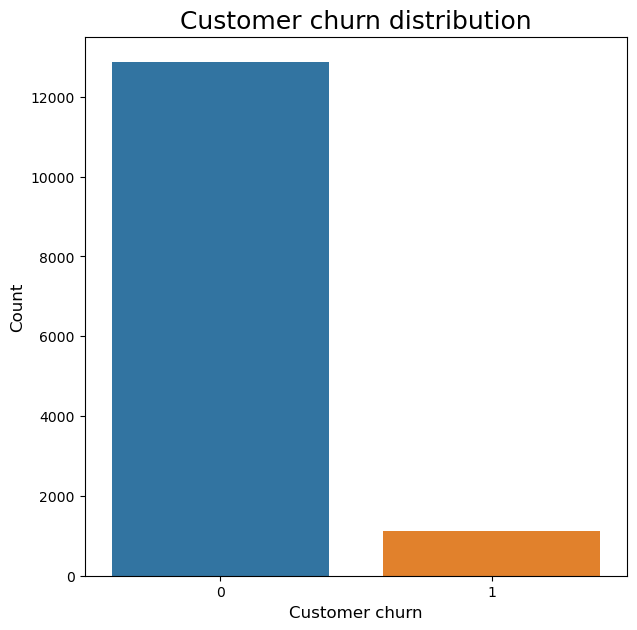

In [113]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = hvc_train['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

#### Based on the visualization, it's evident that 91.98% of customers are non-churn, while 8.26% of customers churn. This indicates a noticeable class imbalance, which we will address later.

In [115]:
# Create a copy of high_val_train df and use the new df (churn_data) for pruning in the training set
churn_data = hvc_train.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)

In [116]:
hvc_train.shape
#churn_data.shape

(13982, 149)

In [117]:
# Get the list of columns with missing values in the training set
mv = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
s = mv.loc[mv>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [118]:
# Lets try to verify how many values are missing from the dataframe
drop = hvc_train.dropna()
print(churn_data.shape[0] - drop.shape[0])

659


### 3.5. Impute missing values using KNN Imputer - Training Set

We will be using KNNImputer to impute missing values as they cannot be discarded as it can lead to the loss of valuable info.
KNNImputer is a technique used to impute missing values in a dataset based on the values of its nearest neighbors. It works by identifying the k nearest neighbors of each data point with missing values, then averaging or taking a weighted average of the available values from those neighbors to fill in the missing value. This approach leverages the similarity between data points to estimate the missing values more accurately.

In [121]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [122]:
# Separate df having columns to be imputed
df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [123]:
%%time
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

CPU times: total: 11 s
Wall time: 12.9 s


In [124]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.00,0.0,15.73,0.00,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1,859.53,372.71,0.89,293.46,450.11,386.91,0.00,0.00,0.0,0.00,0.00,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.00,0.00,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.0,0.0,0.0,202.08,0.00,0.00,0.0,0.0,0.0,0.00,0.05,0.01,0.00,0.0,0.0,233.28,117.63,30.39,123.78,278.49,148.83,34.31,52.08,23.66,391.38,448.21,202.89,0.00,0.00,0.00,207.03,0.00,0.00,0.00,0.0,0.0,207.03,0.00,0.00,0.13,0.0,0.0,0.0,0.0,0.00,0.0,0.15,0.4
2,8.58,11.48,12.68,133.16,158.73,182.83,0.00,0.00,0.0,0.00,0.00,0.0,8.58,11.48,12.68,96.91,149.44,157.23,33.71,9.28,25.59,0.00,0.00,0.00,139.21,170.21,195.51,0.00,0.00,0.00,2.53,0.00,0.00,0.0,0.0,0.0,2.53,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,51.74,83.83,82.81,129.01,214.49,159.69,87.28,67.69,107.94,268.04,366.03,350.46,0.00,0.00,0.40,0.00,0.00,0.00,15.43,0.0,0.0,15.43,0.00,0.40,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,64.66,598.74,565.66,37.83,339.28,558.59,0.00,0.00,0.0,0.00,0.00,0.0,1.60,13.66,20.94,0.43,38.58,12.91,0.00,0.00,0.00,0.00,0.00,0.00,2.03,52.24,33.86,63.06,585.08,544.71,36.43,287.23,545.68,0.0,0.0,0.0,99.49,872.31,1090.39,0.0,0.0,0.0,0.96,13.46,0.00,0.00,0.0,0.0,1.73,5.69,7.84,8.43,12.64,10.09,0.00,0.00,4.85,10.16,18.34,22.79,156.98,93.06,173.33,90.18,86.06,73.61,0.00,0.0,0.0,247.16,179.13,246.94,0.00,0.0,0.0,0.0,0.0,40.54,0.0,0.00,0.0
4,872.16,546.06,1078.93,410.56,420.19,225.53,8.83,149.04,0.0,6.43,388.73,0.0,75.24,62.19,69.71,167.34,162.36,165.78,0.00,2.35,1.18,2.44,0.25,0.18,242.59,226.91,236.68,791.49,221.51,1009.21,232.68,99.08,28.79,0.0,0.0,0.0,1024.18,320.59,1038.01,0.0,0.0,0.0,17.49,36.41,33.16,3.78,0.0,0.0,36.96,128.29,69.49,490.64,223.73,203.76,0.00,1.60,0.66,527.61,353.63,273.93,5.11,9.49,4.16,41.31,90.01,101.68,0.00,0.0,0.0,46.43,99.51,105.84,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0


In [125]:
# Merge the two dataframes together post imputation to create the final training set
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.00,0.0,15.73,0.00,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,240.708,128.191,101.565,63.26,42.94,15.76,21.54,9.36,28.31,13,10,8,290,136,122,50,41,30,25,10,30,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,390.80,308.89,213.47,0.00,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0,1515.0,1473.0,1494.0
1,859.53,372.71,0.89,293.46,450.11,386.91,0.00,0.00,0.0,0.00,0.00,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.00,0.00,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.0,0.0,0.0,202.08,0.00,0.00,0.0,0.0,0.0,0.00,0.05,0.01,0.00,0.0,0.0,233.28,117.63,30.39,123.78,278.49,148.83,34.31,52.08,23.66,391.38,448.21,202.89,0.00,0.00,0.00,207.03,0.00,0.00,0.00,0.0,0.0,207.03,0.00,0.00,0.13,0.0,0.0,0.0,0.0,0.00,0.0,0.15,0.4,1130.948,905.506,479.762,1152.99,822.83,387.81,598.54,448.36,203.29,26,19,10,1420,990,494,110,110,144,110,50,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,455,0.00,0.00,0.00,0,1420.0,990.0,1205.0
2,8.58,11.48,12.68,133.16,158.73,182.83,0.00,0.00,0.0,0.00,0.00,0.0,8.58,11.48,12.68,96.91,149.44,157.23,33.71,9.28,25.59,0.00,0.00,0.00,139.21,170.21,195.51,0.00,0.00,0.00,2.53,0.00,0.00,0.0,0.0,0.0,2.53,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,51.74,83.83,82.81,129.01,214.49,159.69,87.28,67.69,107.94,268.04,366.03,350.46,0.00,0.00,0.40,0.00,0.00,0.00,15.43,0.0,0.0,15.43,0.00,0.40,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0

In [126]:
final_df.shape

(13982, 149)

In [127]:
# Verify no missing value is present in the training set now
final_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_7      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
count_rech_3g_8       0
total_rech_amt_8      0
total_rech_amt_6      0
isd_ic_mou_6          0
total_rech_num_8      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
vol_3g_mb_6           0
monthly_3g_7          0
monthly_3g_8    

### 3.6. Impute missing values using the KNN Imputer - Unseen Test Set

In [129]:
# Separate df having columns to be imputed
df_num_unseen = unseen[impute_cols_num]
churn_df_unseen = unseen.drop(impute_cols_num, axis=1)

In [130]:
%%time
# Impute using KNN imputer instance
df_imp_unseen = imputer.transform(df_num_unseen)

CPU times: total: 53.1 s
Wall time: 1min 5s


In [131]:
# Convert it to df post imputation
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
df_imp_unseen.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00
1,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00
2,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00
3,5.31,2.16,0.00,40.04,205.01,24.01,0.00,0.00,0.00,0.00,0.00,0.00,5.31,0.00,0.00,2.94,98.61,20.51,0.00,0.00,2.35,0.0,6.18,0.00,8.26,98.61,22.86,0.00,2.16,0.00,37.09,94.36,0.00,0.0,0.0,0.0,37.09,96.53,0.00,0.0,0.0,0.0,0.00,12.03,1.15,0.0,0.0,0.0,58.11,54.64,23.04,487.94,449.83,506.94,0.00,0.38,1.64,546.06,504.86,531.64,0.00,4.26,0.00,9.63,11.88,8.83,0.0,0.0,0.00,9.63,16.14,8.83,0.00,0.00,0.00,0.00,1.43,8.65,0.0,0.0,0.00
4,450.93,609.03,700.68,60.94,23.84,74.16,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.78,14.56,2.39,2.66,10.94,0.00,0.00,0.00,0.0,0.00,0.00,2.84,3.44,25.51,450.48,608.24,686.11,58.54,21.18,63.18,0.0,0.0,0.0,509.03,629.43,749.29,0.0,0.0,0.0,0.71,5.39,4.96,2.2,0.0,0.0,0.00,0.36,9.91,10.13,9.23,7.69,0.00,0.00,0.00,10.13,9.59,17.61,29.71,92.36,107.39,13.88,13.96,32.46,0.0,0.0,1.61,43.59,106.33,141.48,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.16


In [132]:
# Merge the two dataframes together post imputation
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
final_unseen_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,id,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,69999,91.882,65.330,64.445,91.94,52.39,57.94,41.73,43.56,36.26,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1692,0.00,0.00,0.00,103.0,90.0,96.5
1,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,70000,414.168,515.568,360.868,549.86,663.06,415.59,296.33,339.64,281.66,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,2533,0.00,0.00,0.00,500.0,500.0,500.0
2,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,70001,329.844,434.884,746.239,0.00,0.00,0.00,0.00,0.00,0.00,6,9,5,500

In [133]:
#missing_cols = [col for col in impute_cols_num if col not in unseen.columns]
#if missing_cols:
#    print(f"These columns are missing in unseen: {missing_cols}")

In [134]:
#impute_cols_num = [col for col in impute_cols_num if col in unseen.columns]

In [135]:
#fit_columns = impute_cols_num

In [136]:
#df_num_unseen = df_num_unseen.reindex(columns=fit_columns)

In [137]:
print(f"Columns in fit: {impute_cols_num}")
print(f"Columns in df_num_unseen: {df_num_unseen.columns.tolist()}")


Columns in fit: ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f

In [138]:
#imputer = KNNImputer(n_neighbors=5)
#imputer.fit(df_num_unseen)

In [139]:
#df_imp_unseen = imputer.transform(df_num_unseen)

In [140]:
unseen.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1692,0.00,0.00,0.00,103.0,90.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,2533,0.00,0.00,0.00,500.0,500.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6,9,5,500

In [141]:
# Convert it to df post imputation
#df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
#df_imp_unseen.head()

In [142]:
# Merge the two dataframes together post imputation
#final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
#final_unseen_df.head()

In [143]:
final_unseen_df.shape

(30000, 149)

In [144]:
# Verify no missing value is present in the test set now
final_unseen_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_6      0
total_rech_amt_8      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
total_rech_amt_7      0
total_rech_num_8      0
isd_ic_mou_6          0
total_rech_num_7      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
id                    0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
count_rech_3g_8       0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
monthly_3g_6          0
monthly_3g_7    

In [145]:
def plot_bar_graph(title, month, y_list, data):
    """
    Plot bar graphs for given data.

    Parameters:
    - title (str): Title of the plot.
    - month (list of str): List of month names.
    - y_list (list of str): List of y-variable names corresponding to each month.
    - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
    - None

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.
    """
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

In [146]:
def outlier_handling(dataframe):
    """
    Applies outlier handling transformations to the values in the given DataFrame.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the values to be transformed.

    Returns:
    - transformed_values (list): A list containing the transformed values based on the specified conditions.
    """

    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

In [147]:
def calculate_classification_metrics(y_true, y_pred):
    """
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [148]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

### 4. Exploratory Data Analysis (EDA)

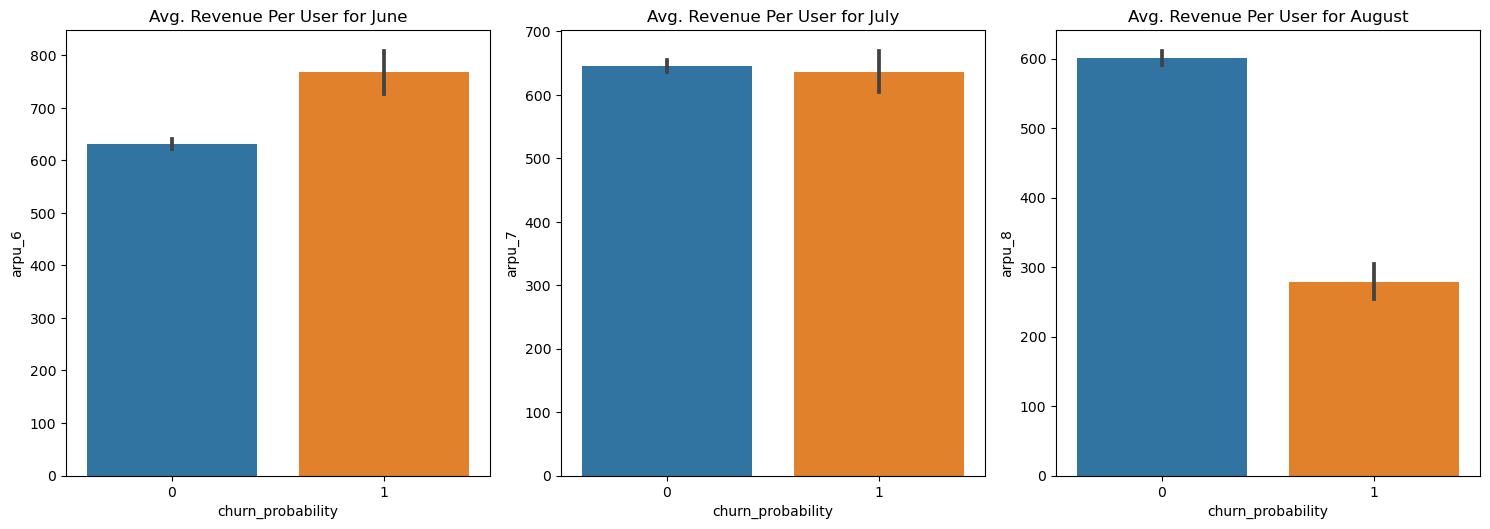

In [150]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

##### The decline in the Average Revenue Per User (ARPU) in month of August suggests churn.

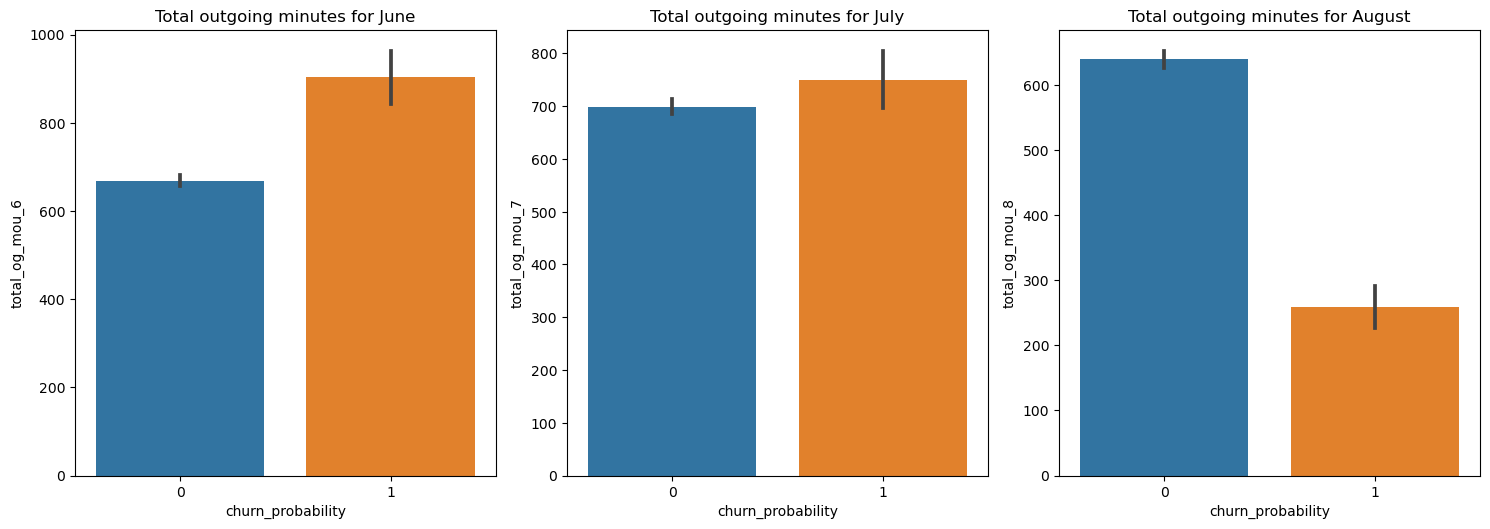

In [152]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

##### The decline in the Total Outgoing minutes in month of August suggests churn.

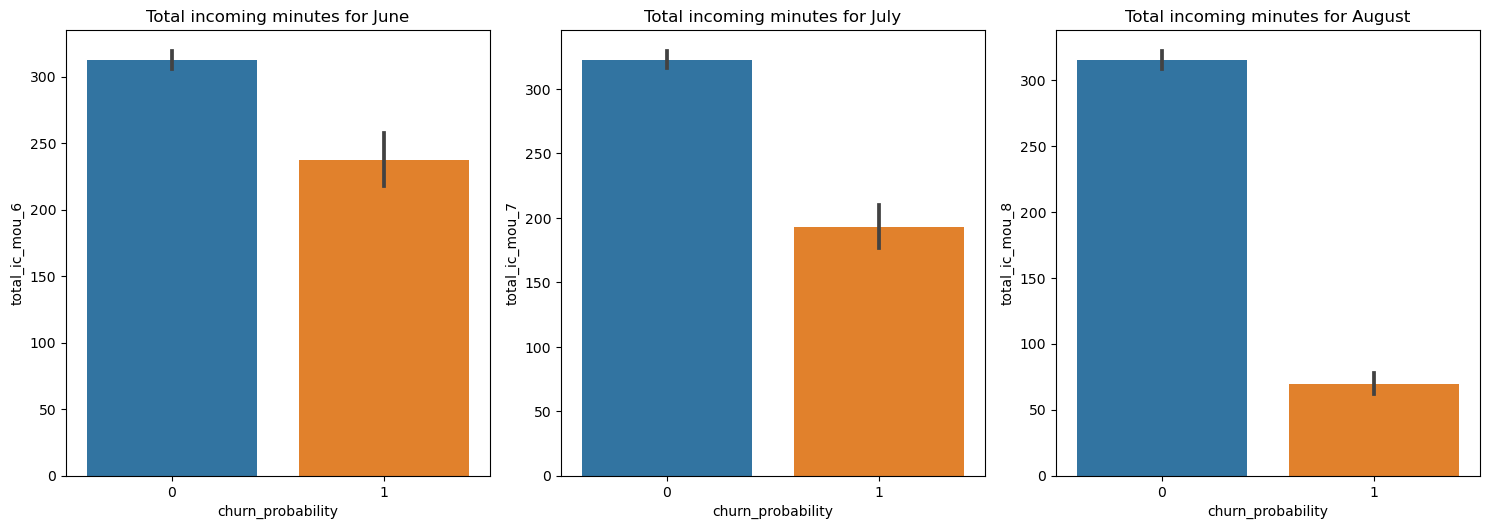

In [154]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

##### The decline in the Total Incoming minutes in month of August suggests churn.

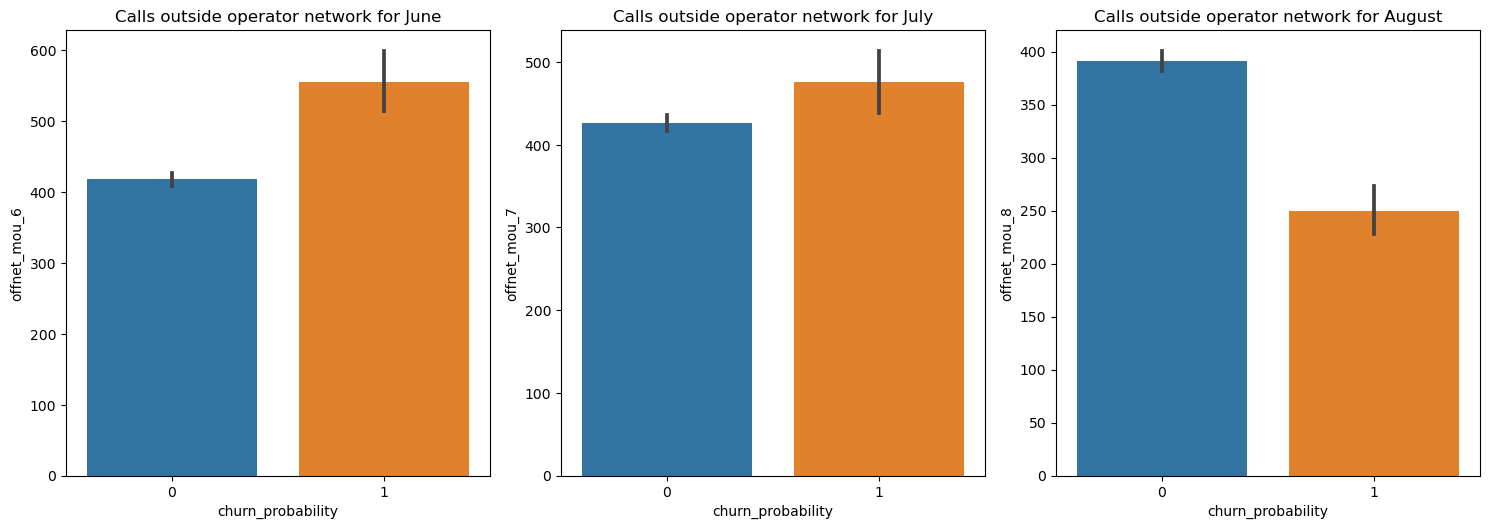

In [156]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_df)

##### The decline in the Calls outside operator network in month of August suggests churn.

In [158]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]

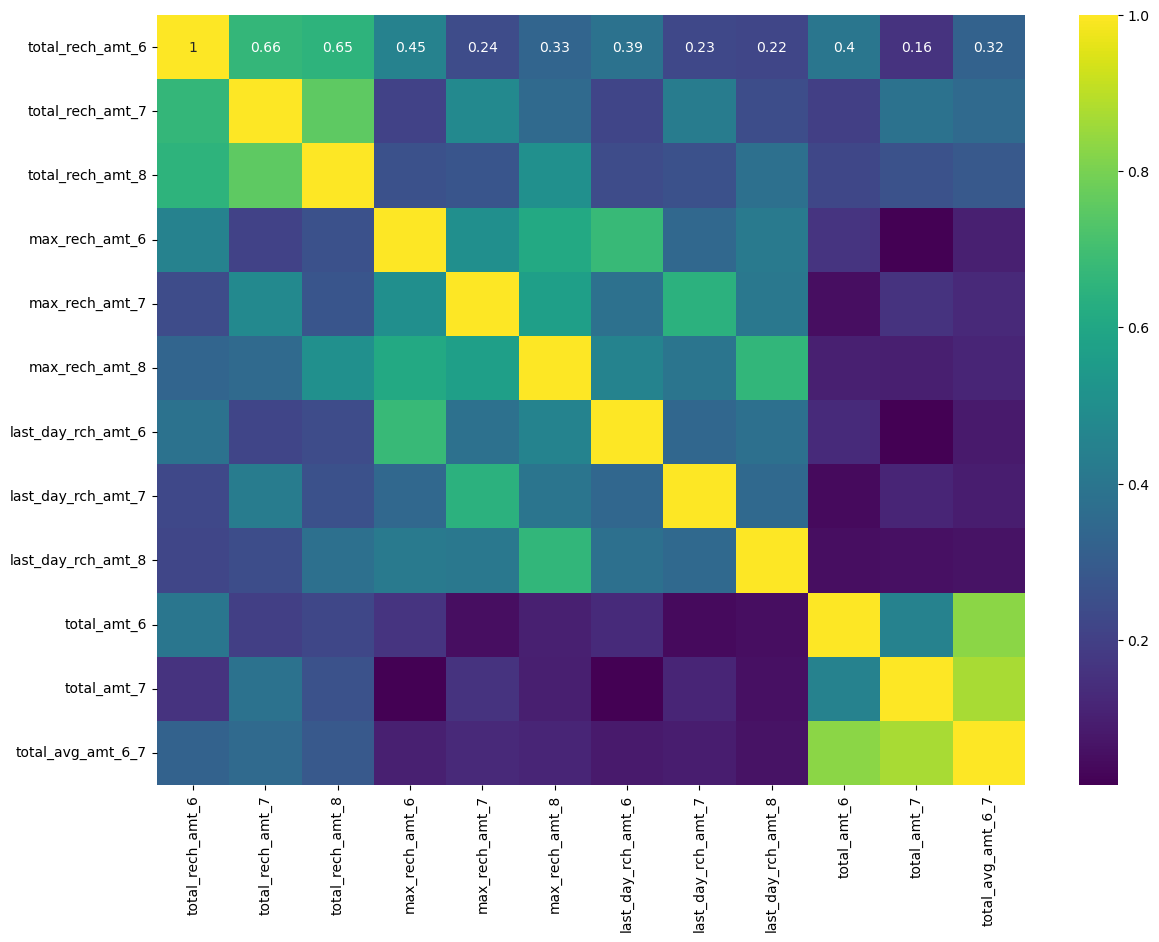

In [159]:
# Amount data
plt.figure(figsize=(14,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

***Observations:***
- A substantial correlation of 65% exists between the total recharge amount in month 7 and month 8.
- Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
- This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

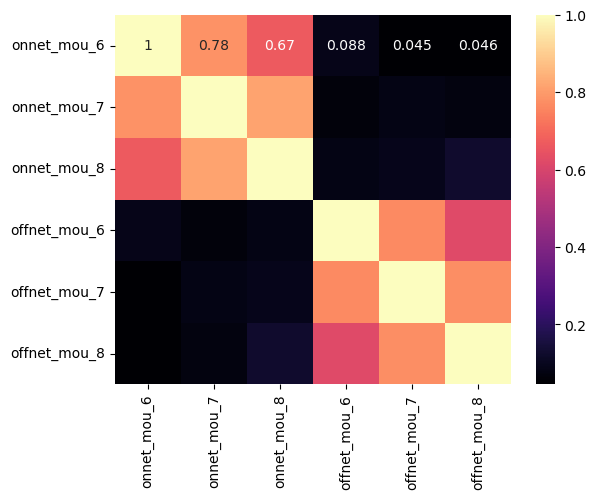

In [161]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='magma')
plt.show()

***Observations:***
- There is no correlation between the usage minutes for on-net and off-net calls.
- However, a significant correlation is observed between the on-net and off-net usage minutes in both months 7 and 8.

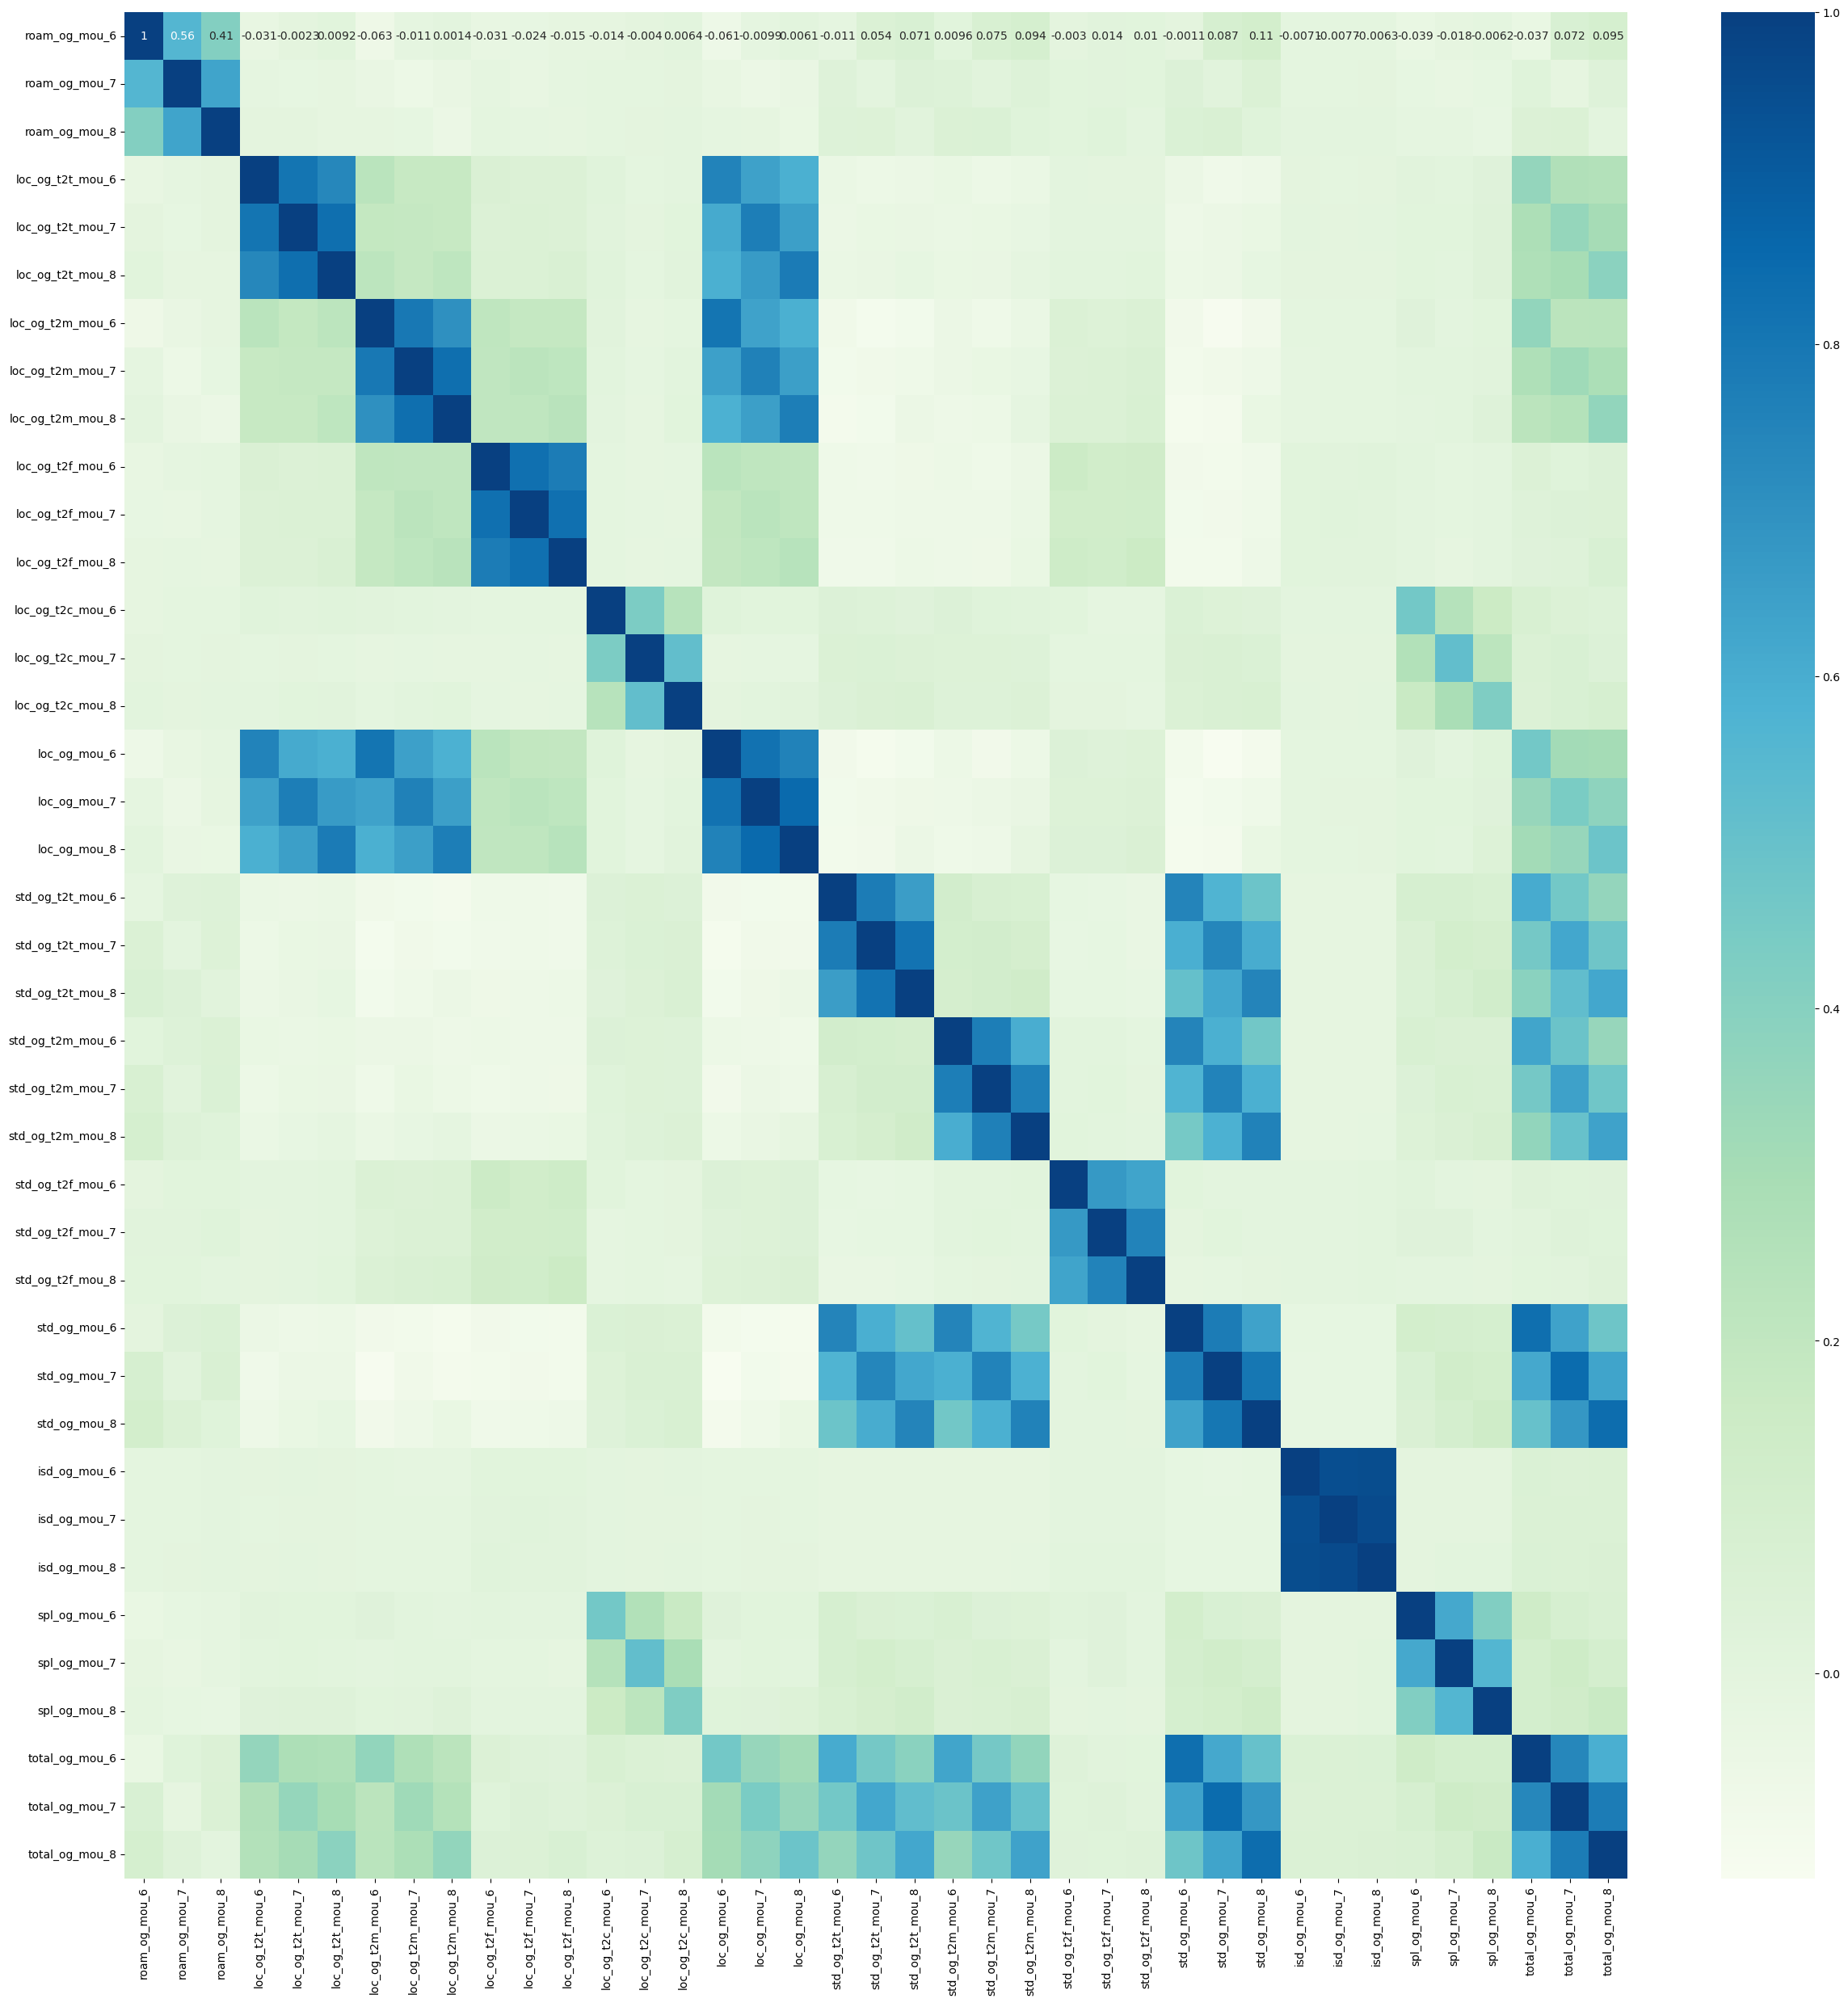

In [163]:
#og_mou_data
plt.figure(figsize=(30,30))
sns.heatmap(og_mou_data.corr(), annot=True, cmap='GnBu')
plt.show()

***Observations:***
- There exists a very high correlation between the following variables/features:
  1. isd_og_mou_7 and isd_og_mou_6
  2. isd_og_mou_8 and isd_og_mou_6
  3. isd_og_mou_8 and isd_og_mou_7
  4. total_og_mou_6 and std_og_mou_6
  5. total_og_mou_7 and std_og_mou_7
  6. total_og_mou_8 and std_og_mou_8

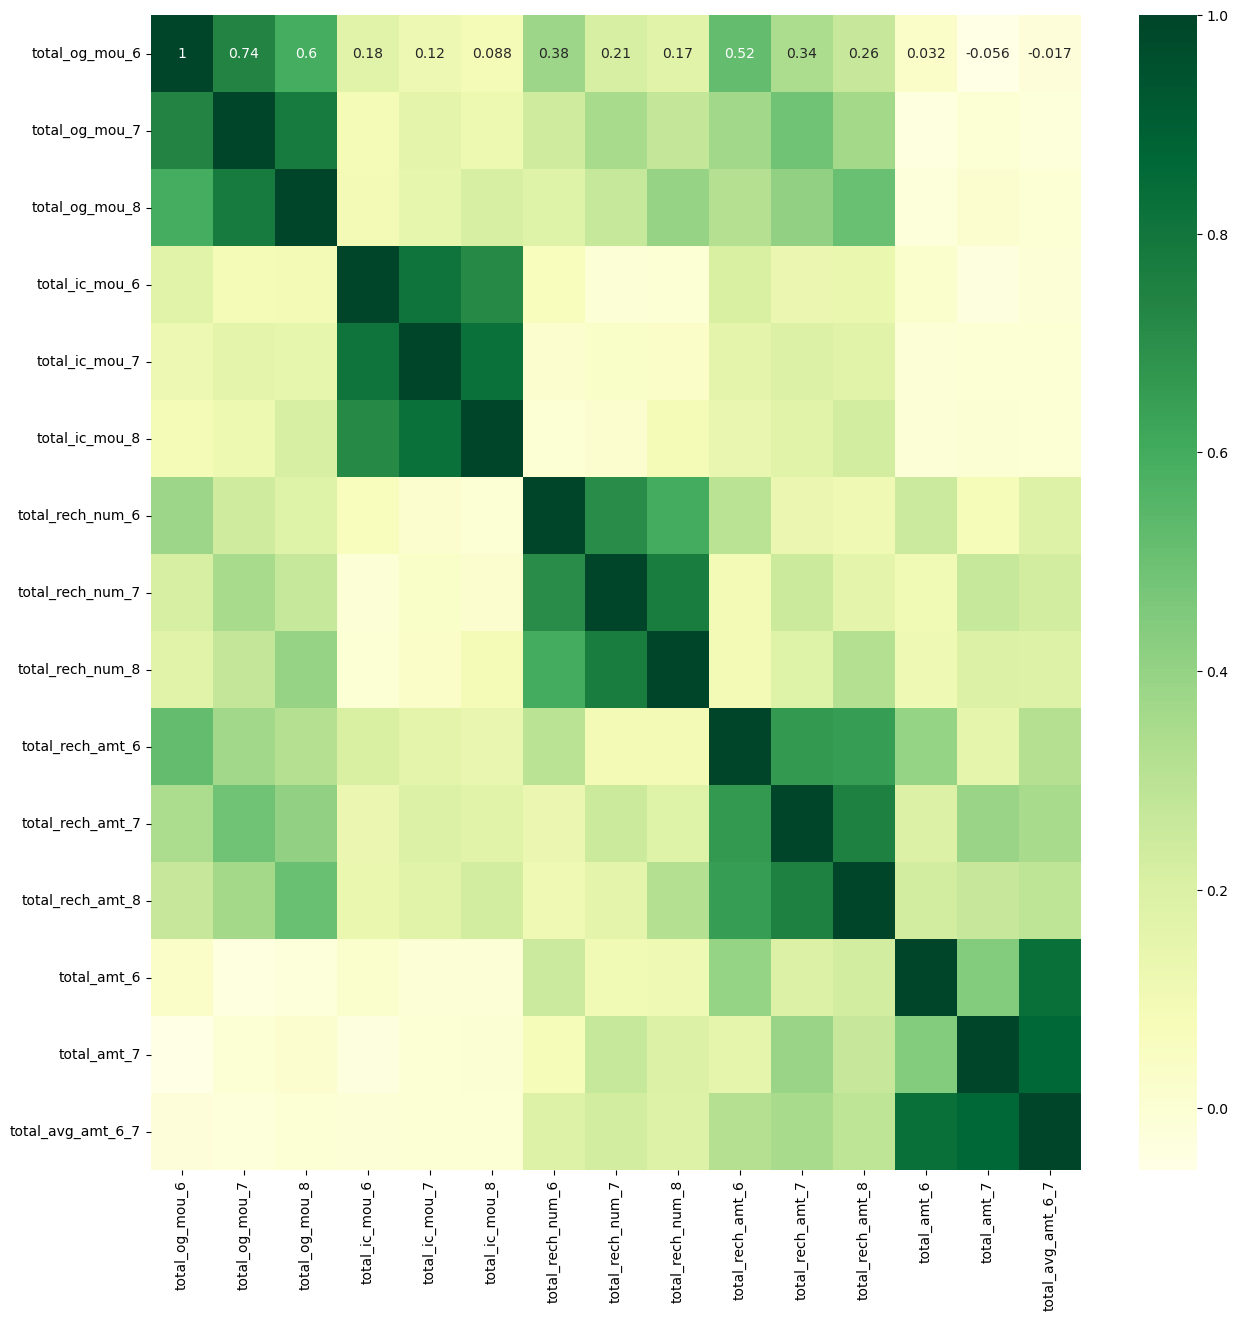

In [165]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='YlGn')
plt.show()

***Observations:***
- There exists a remarkably high correlation between the incoming (81%) and outgoing minutes (71%) of usage in months 7 and 8.
- Heavy usage suggests that customers are less likely to churn.

In [167]:
# Inspecting shape of the training dataset
final_df.shape

(13982, 149)

In [168]:
final_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.00,0.0,15.73,0.00,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,240.708,128.191,101.565,63.26,42.94,15.76,21.54,9.36,28.31,13,10,8,290,136,122,50,41,30,25,10,30,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,390.80,308.89,213.47,0.00,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0,1515.0,1473.0,1494.0
1,859.53,372.71,0.89,293.46,450.11,386.91,0.00,0.00,0.0,0.00,0.00,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.00,0.00,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.0,0.0,0.0,202.08,0.00,0.00,0.0,0.0,0.0,0.00,0.05,0.01,0.00,0.0,0.0,233.28,117.63,30.39,123.78,278.49,148.83,34.31,52.08,23.66,391.38,448.21,202.89,0.00,0.00,0.00,207.03,0.00,0.00,0.00,0.0,0.0,207.03,0.00,0.00,0.13,0.0,0.0,0.0,0.0,0.00,0.0,0.15,0.4,1130.948,905.506,479.762,1152.99,822.83,387.81,598.54,448.36,203.29,26,19,10,1420,990,494,110,110,144,110,50,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,455,0.00,0.00,0.00,0,1420.0,990.0,1205.0
2,8.58,11.48,12.68,133.16,158.73,182.83,0.00,0.00,0.0,0.00,0.00,0.0,8.58,11.48,12.68,96.91,149.44,157.23,33.71,9.28,25.59,0.00,0.00,0.00,139.21,170.21,195.51,0.00,0.00,0.00,2.53,0.00,0.00,0.0,0.0,0.0,2.53,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,51.74,83.83,82.81,129.01,214.49,159.69,87.28,67.69,107.94,268.04,366.03,350.46,0.00,0.00,0.40,0.00,0.00,0.00,15.43,0.0,0.0,15.43,0.00,0.40,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0

In [169]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13982 entries, 0 to 13981
Columns: 149 entries, onnet_mou_6 to total_avg_amt_6_7
dtypes: category(7), float64(117), int64(25)
memory usage: 15.2 MB


In [170]:
# Inspecting the shape of the test set
final_unseen_df.shape

(30000, 149)

In [171]:
final_unseen_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,id,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,69999,91.882,65.330,64.445,91.94,52.39,57.94,41.73,43.56,36.26,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1692,0.00,0.00,0.00,103.0,90.0,96.5
1,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,70000,414.168,515.568,360.868,549.86,663.06,415.59,296.33,339.64,281.66,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,2533,0.00,0.00,0.00,500.0,500.0,500.0
2,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,70001,329.844,434.884,746.239,0.00,0.00,0.00,0.00,0.00,0.00,6,9,5,500

In [172]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 149 entries, onnet_mou_6 to total_avg_amt_6_7
dtypes: category(6), float64(117), int64(26)
memory usage: 32.9 MB


### 5. Dummy Variable Creation (One Hot Encoding) - Training Set

In [174]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [175]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [176]:
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [177]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13982 entries, 0 to 13981
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int32(12), int64(25)
memory usage: 15.8 MB


In [178]:
final_df.shape

(13982, 155)

### 6. Dummy Variable Creation (One Hot Encoding) - Test Set

In [180]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [181]:
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)

In [182]:
# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [183]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int32(12), int64(26)
memory usage: 34.1 MB


### 7. Outlier Treatment

In [185]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.00000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.00000,13982.00000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.00000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.

In [186]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))
numerical_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

##### The `outlier_handling` method treats outliers and adjusts skewness in the dataset to improve data robustness and analysis accuracy.

In [188]:
# Handle outliers of numerical columns in the training set
final_df[numerical_cols] = final_df[numerical_cols].apply(outlier_handling)

In [189]:
# Inspecting the numerical columns again in the training set
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13982.000000,13

In [190]:
# Inspecting the numerical columns again in the test set
final_unseen_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,id,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3

### 8. Model Building and Evaluation

#### Train-Test Split

Given the availability of the `test.csv` file for testing purposes, this train-test split will exclusively operate on the `train.csv` dataset. It involves allocating 80% of the data for training and 20% for validation.

In [196]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [198]:
X.shape

(13982, 154)

In [200]:
y.shape

(13982,)

In [202]:
X.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
0,3.103689,1.763017,1.964311,4.060271,3.666378,2.363680,4.000766,0.000000,0.0,2.817204,0.000000,0.0,2.412336,1.763017,1.964311,3.630721,3.038792,1.724551,2.564180,0.802002,1.793425,0.000000,2.384165,0.000000,4.092843,3.293612,2.818995,0.00000,0.000000,0.000000,1.677097,0.000000,0.000000,0.0,0.0,0.0,1.677097,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.890372,0.000000,0.000000,0.0,0.0,1.862529,0.871293,1.297463,2.449279,1.673351,3.019937,1.873339,1.532557,1.965713,3.115292,2.337952,3.377929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,5.487730,4.861292,4.630497,4.162937,3.782825,2.818995,3.115292,2.337952,3.377929,2.639057,2.397895,2.197225,5.673323,4.919981,4.812184,3.931826,3.737670,3.433987,3.258097,2.397895,3.433987,3.258097,3.737670,3.258097,2.079442,1.94591,1.94591,0.000000,1.500000,0.000000,5.970752,5.736217,5.368170,0.000000,0.000000,0.000000,0.000000,3.583519,0.000000,0.000000,3.586847,0.000000,0.000000,0.0,0.0,2.079442,1.94591,1.94591,0.0,0.0,0.0,0.000000,1.500000,0.0,6.473891,0.000000,0.000000,0.000000,7.323831,7.295735,7.309881,1.5,0.0,0.0,1.5,0.0,1.5,0.0,1.5,1.5,0.0,1.5,0.0
1,6.757548,5.923480,0.636577,5.685143,6.111711,5.960773,0.000000,0.000000,0.0,0.000000,0.000000,0.0,6.757548,5.923480,0.636577,4.391853,6.053570,5.937563,2.532108,3.274500,2.290513,0.000000,0.000000,0.000000,6.858470,6.713904,5.963039,0.00000,0.000000,0.000000,5.313600,0.000000,0.000000,0.0,0.0,0.0,5.313600,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.048790,0.009950,0.000000,0.0,0.0,5.456517,4.776009,3.446489,4.826552,5.632967,5.009501,3.564166,3.971800,3.205182,5.972231,6.107490,5.317581,0.000000,0.000000,0.000000,5.337682,0.000000,0.000000,0.000000,0

In [204]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: category
Categories (2, int64): [0, 1]

In [206]:
# Train test split - 80% training data, 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=100)

In [208]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (11185, 154)
y_train Shape: (11185,)
X_val Shape: (2797, 154)
y_val Shape: (2797,)


In [210]:
y_train.value_counts()

churn_probability
0    10290
1      895
Name: count, dtype: int64

### 8.1. Handling Data Imbalance using Synthetic Minority Over-sampling Technique (SMOTE)

In [212]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [214]:
X_train_smote.shape

(20580, 154)

In [216]:
y_train_smote.shape

(20580,)

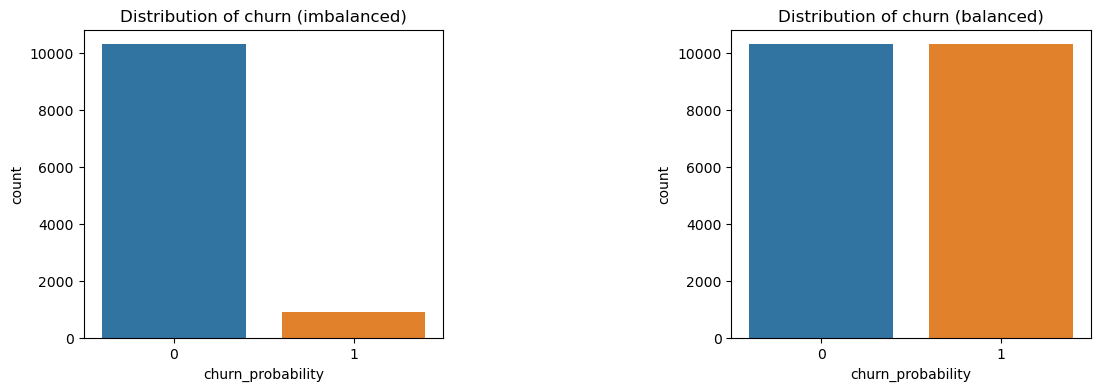

In [218]:
# Checking the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(13, 4))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

##### data imbalance issue is sorted now

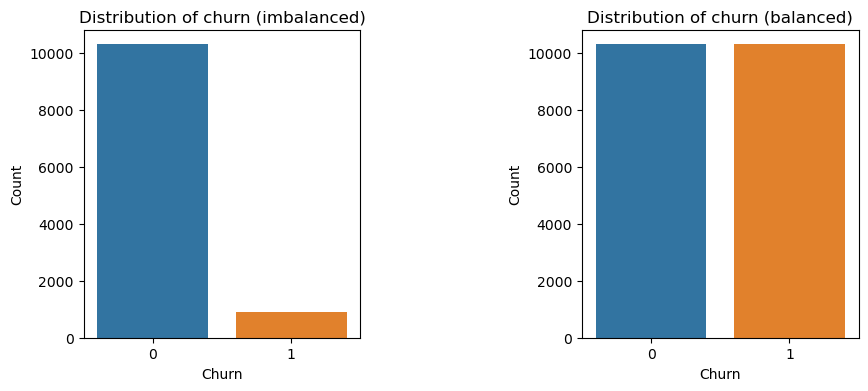

In [220]:
plt.figure(figsize=(10, 4))

# Before SMOTE
plt.subplot(1, 2, 1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train)
plt.xlabel("Churn")
plt.ylabel("Count")

# After SMOTE
plt.subplot(1, 2, 2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote)
plt.xlabel("Churn")
plt.ylabel("Count")

plt.subplots_adjust(wspace=0.8)
plt.show()

##### The data imbalance issue is sorted now.

### 8.2. Feature Scaling using SandardScaler - Training Set

In [222]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

In [224]:
X_train_scaled.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
0,-1.595662,-1.659988,0.110456,-1.222717,-1.607975,-0.089490,-0.52776,-0.532968,-0.687024,-0.540841,-0.569134,-0.729822,-1.103591,-1.226647,0.721734,-2.263703,-2.016475,0.408737,-0.747561,0.625601,1.609221,3.662825,-0.564441,-0.557428,-1.805497,-1.300792,0.506604,-1.102744,-1.043814,-0.045262,-1.328095,-1.253706,-1.090468,-0.371216,-0.363678,-0.354911,-1.485120,-1.398300,-0.412175,-0.293604,-0.284094,-0.313785,1.733113,0.457063,-0.907893,-0.569840,-0.063749,-0.071968,-0.091902,-0.213587,0.687788,-0.070915,-0.357650,0.595021,1.090409,1.117200,1.010091,-0.049797,-0.208428,0.578817,-0.952185,0.840529,-0.815957,-1.316450,-1.227825,0.414871,-0.473791,4.060851,-0.459177,-1.568774,0.825200,0.130757,-0.483962,-0.203977,-0.267626,1.946284,1.554769,-0.527633,5.757319,2.827870,-0.418217,0.359870,0.421813,0.793035,-0.966417,-1.208506,0.348891,0.150850,0.169982,0.679912,-0.172188,-0.510109,-0.682453,0.458617,0.438908,0.745053,1.289422,0.704005,0.857734,1.426207,1.124619,1.427209,1.518652,1.318800,1.622727,-0.827640,-0.809103,-0.662547,1.047346,1.136544,1.455350,-0.902056,-0.830817,-0.646140,1.749025,1.789640,2.106323,2.045014,2.090713,2.462580,1.940857,1.897574,2.362109,-0.375613,-0.379796,-0.312031,-0.692904,-0.673126,-0.562318,1.622692,1.756965,2.033598,-0.407969,-0.389578,-0.287909,0.407874,-0.601703,-0.694182,-0.689449,0.765093,0.579065,1.289882,1.206159,-0.104836,-0.259139,1.321851,-0.216934,0.995395,-0.220877,0.937261,0.947368,-0.123671,0.900195,-0.141744
1,-2.125912,-1.872604,-1.657714,-1.104401,-1.968747,-1.786286,-0.52776,-0.532968,-0.687024,-0.540841,-0.569134,-0.729822,-1.742150,-1.481760,-1.224755,-1.368481,-1.243235,-1.335977,-0.747561,-0.731901,-0.709419,-0.549377,-0.564441,-0.557428,-1.546047,-1.376482,-1.355573,-1.102744,-1.043814

### 8.3. Feature Scaling using StandardScaler - Unseen Test Set

In [226]:
final_unseen_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,id,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
0,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,69999,91.882,65.330,64.445,91.94,52.39,57.94,41.73,43.56,36.26,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1692,0.00,0.00,0.00,103.0,90.0,96.5,0,0,0,0,0,0,0,0,0,0,0,0
1,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,70000,414.168,515.568,360.868,549.86,663.06,415.59,296.33,339.64,281.66,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2533,0.00,0.00,0.00,500.0,500.0,500.0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,

In [228]:
final_unseen_df.set_index('id', inplace=True)

### Model 1. Logistic Regression with Recursive Feature Elimination (RFE)

In [230]:
%%time
# Select top 20 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

CPU times: total: 7min 46s
Wall time: 11min 54s


In [236]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 58),
 ('onnet_mou_7', False, 51),
 ('onnet_mou_8', False, 49),
 ('offnet_mou_6', False, 23),
 ('offnet_mou_7', False, 2),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 14),
 ('roam_ic_mou_7', False, 114),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 13),
 ('roam_og_mou_7', False, 38),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 30),
 ('loc_og_t2t_mou_7', False, 126),
 ('loc_og_t2t_mou_8', False, 57),
 ('loc_og_t2m_mou_6', False, 28),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2m_mou_8', False, 50),
 ('loc_og_t2f_mou_6', False, 104),
 ('loc_og_t2f_mou_7', False, 76),
 ('loc_og_t2f_mou_8', False, 56),
 ('loc_og_t2c_mou_6', False, 93),
 ('loc_og_t2c_mou_7', False, 64),
 ('loc_og_t2c_mou_8', False, 65),
 ('loc_og_mou_6', False, 29),
 ('loc_og_mou_7', True, 1),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 59),
 ('std_og_t2t_mou_7', False, 60),
 ('std_og_t2t_mou_8', False, 91),
 ('std_og_t2m_mou_6', True, 1),
 ('std_og_t2m_m

In [238]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2m_mou_7',
       'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_7',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8'],
      dtype='object')

In [240]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [242]:
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [244]:
# Calculate metrics on the training set
calculate_classification_metrics(y_train_smote, y_train_smote_pred)

Confusion Matrix

[[9049 1241]
 [1601 8689]]


,Metric,Value
0,Accuracy,0.8619
1,Sensitivity,0.8444
2,Specificity,0.8794
3,Precision,0.8750
4,False Positive Rate,0.1206
5,True Positive Rate,0.8444


In [246]:
# Retain only the selected feature from the final model
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2m_mou_7,loc_og_mou_7,loc_og_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_8,std_og_mou_6,std_og_mou_7,spl_ic_mou_8,isd_ic_mou_8,total_ic_mou_7,total_ic_mou_8,total_rech_num_7,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,max_rech_data_8
770,0.537670,-0.687024,-0.729822,1.070168,0.885535,0.893777,-1.328095,-0.883214,-1.485120,-0.385447,-0.267626,-0.535396,0.374774,0.887535,-0.510109,0.479721,0.696634,0.624205,1.133167,1.405198
140,-0.964740,-0.687024,-0.729822,-0.523083,-0.648461,-0.427545,-1.328095,-1.090468,-1.485120,-0.851027,-0.267626,-0.535396,-0.776060,0.014578,0.782638,0.600608,0.347105,0.001850,0.624988,0.825482
9125,-2.389638,-0.687024,-0.729822,-2.106497,-2.235921,-1.757874,-1.328095,-1.090468,-1.485120,-1.398300,1.168871,-0.535396,-1.589584,-0.538279,-1.259367,-1.047334,0.136135,0.618015,-1.044781,1.399432
6048,0.451247,-0.687024,-0.729822,0.805651,1.156299,1.257080,-1.328095,-1.090468,-1.224671,-1.398300,-0.267626,-0.535396,0.847163,1.168788,-0.510109,0.906485,0.937378,1.138516,-1.044781,1.884271
1010,-0.526786,-0.687024,-0.729822,-0.646079,-0.571009,0.012986,-1.328095,-1.090468,-1.481582,-1.398300,4.695578,-0.535396,-0.054572,0.535377,0.263865,0.993992,0.214717,-0.226727,0.246465,0.612566


In [248]:
# Get the predicted values from the linear model
y_val_pred = logreg.predict(X_val_scaled_final)

In [250]:
confusion = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
print(confusion)

[[2305  267]
 [  48  177]]


In [252]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred)
metrics_df

Confusion Matrix

[[2305  267]
 [  48  177]]


,Metric,Value
0,Accuracy,0.8874
1,Sensitivity,0.7867
2,Specificity,0.8962
3,Precision,0.3986
4,False Positive Rate,0.1038
5,True Positive Rate,0.7867


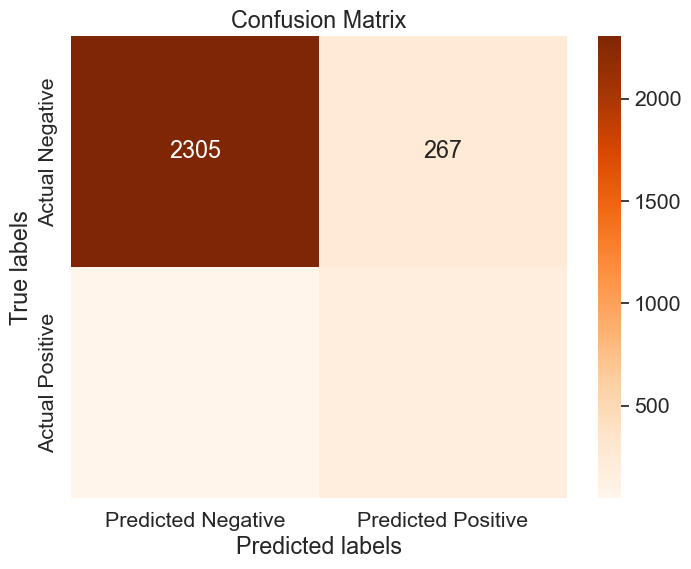

In [254]:
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix into a 2x2 array
cm_array = np.array(confusion).reshape(2,2)

# Create the heatmap
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(cm_array, annot=True, cmap='Oranges', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

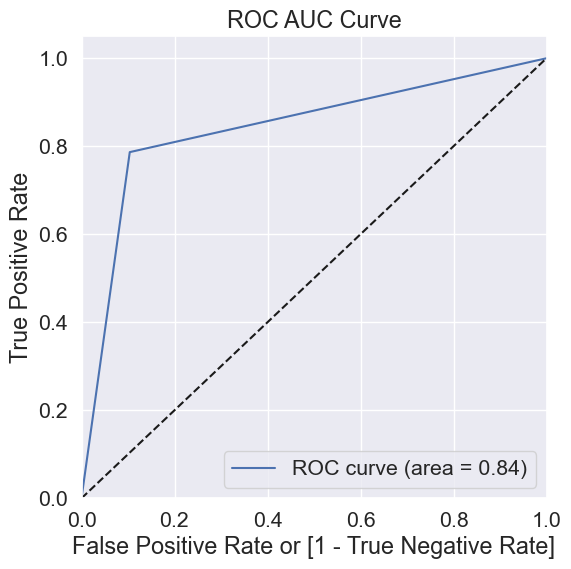

In [256]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [258]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.84'

In [260]:
submission_data = final_unseen_df[selected_features]
submission_data.shape

(30000, 20)

In [262]:
final_unseen_df['churn_probability'] = logreg.predict(submission_data)
output = final_unseen_df[['churn_probability']]
output.head()

,churn_probability
id,
69999,0
70000,0
70001,0
70002,0
70003,0


In [264]:
output.to_csv('submission1211.csv',index=True)

### Model 2. Logistic Regression with PCA and Hyperparameter Tuning

In [269]:
pca = PCA()

In [271]:
pca_components = pca.fit_transform(X_train)
pca_components

array([[-1.36401238e+01,  3.41893878e+00,  1.82320314e+00, ...,
         3.55831596e-14, -1.72759547e-14, -2.69058429e-14],
       [-2.44726716e+01, -8.95173497e-03,  7.76265872e+00, ...,
        -1.94237864e-15,  7.92610795e-15, -2.61286868e-14],
       [-1.03217492e+01,  2.77256384e+00, -1.87635630e+00, ...,
        -1.27624482e-15,  3.76591382e-16, -2.60490288e-16],
       ...,
       [-1.43921226e+01,  1.26973390e+01, -3.46550599e+00, ...,
         2.94260267e-15,  2.48601513e-15,  9.95356154e-15],
       [-6.71506357e+00,  1.45740536e+01,  4.52851810e+00, ...,
        -6.82735995e-15, -4.50838993e-15,  9.95356154e-15],
       [-1.35377135e+01, -2.03535350e+01, -3.23521351e-01, ...,
        -1.47053385e-15,  4.92850578e-15, -1.16957874e-14]])

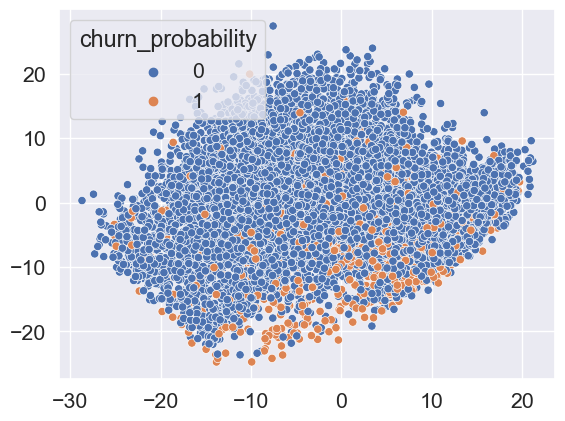

In [273]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

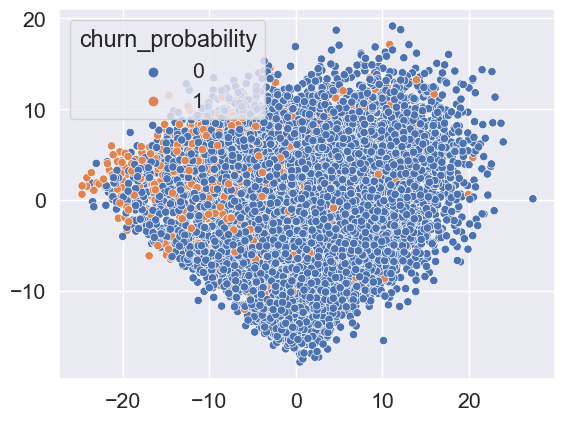

In [275]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

In [279]:
X = hvc_train.copy().drop(['churn_probability'], axis=1)
y = hvc_train.copy()['churn_probability']

In [281]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

In [283]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=20)
smote = SMOTE(random_state=2)
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [285]:
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    lr
)

In [287]:
# Define hyperparameters grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
}

In [289]:
# Instantiate GridSearchCV
lr_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [291]:
# Fit the model using GridSearchCV
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [293]:
# Predict values on the training set
y_train_pred = lr_grid_search.predict(X_train)

In [295]:
# Predict values on the validation set
y_val_pred = lr_grid_search.predict(X_val)

In [297]:
# Metrics of the training set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[8417 1873]
 [ 180  715]]


,Metric,Value
0,Accuracy,0.8165
1,Sensitivity,0.7989
2,Specificity,0.8180
3,Precision,0.2763
4,False Positive Rate,0.1820
5,True Positive Rate,0.7989


In [299]:
# Metrics of the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[2128  444]
 [  40  185]]


,Metric,Value
0,Accuracy,0.8270
1,Sensitivity,0.8222
2,Specificity,0.8274
3,Precision,0.2941
4,False Positive Rate,0.1726
5,True Positive Rate,0.8222


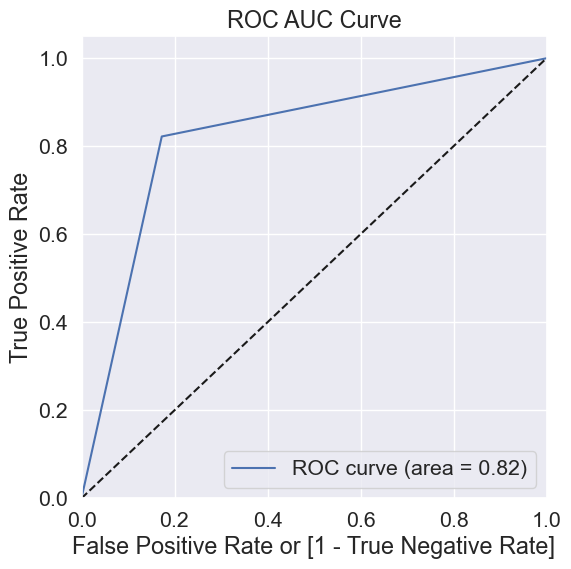

In [301]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### Model 3. Logistic Regression with PCA and Hyperparameter Tuning

In [343]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [345]:
lr.score(pca_components[:,:2], y_train)

0.9205185516316495

In [349]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [351]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [353]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [355]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9223960661600358


In [359]:
test_score = pipe.score(X_val, y_val)
print("Test accuracy:", test_score)

Test accuracy: 0.9224168752234537


In [361]:
confusion_matrix(y_train, pipe.predict(X_train))

array([[10270,    20],
       [  848,    47]], dtype=int64)

In [363]:
confusion_matrix(y_val, pipe.predict(X_val))

array([[2565,    7],
       [ 210,   15]], dtype=int64)

In [369]:
precision_score(y_val, pipe.predict(X_val))

0.6818181818181818

In [371]:
recall_score(y_val, pipe.predict(X_val))

0.06666666666666667

In [373]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [375]:
unseen.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1692,0.00,0.00,0.00,103.0,90.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,2533,0.00,0.00,0.00,500.0,500.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6,9,5,500

In [377]:
submission_data = unseen.set_index('id')
submission_data.shape

(30000, 148)

In [379]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [381]:
output.to_csv('submission_pca_lr_1211.csv',index=False)

In [436]:
# IMP KNN + RF trial
imp = KNNImputer(n_neighbors=5)
lr = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

pipe = Pipeline(steps = [('imputation',imp),
                         ('model',lr)])

In [438]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputation', KNNImputer()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [440]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 1.0


In [442]:
test_score = pipe.score(X_val, y_val)
print("Test accuracy:", test_score)

Test accuracy: 0.9452985341437254


In [444]:
confusion_matrix(y_train, pipe.predict(X_train))

array([[10290,     0],
       [    0,   895]], dtype=int64)

In [446]:
confusion_matrix(y_val, pipe.predict(X_val))

array([[2552,   20],
       [ 133,   92]], dtype=int64)

In [448]:
precision_score(y_val, pipe.predict(X_val))

0.8214285714285714

In [450]:
recall_score(y_val, pipe.predict(X_val))

0.4088888888888889

In [476]:
y_pred = pipe.predict(X_val)

In [482]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy
print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}")
# Precision and Recall
print(f"Precision: {precision_score(y_val, y_pred, average='binary'):.3f}")
print(f"Recall: {recall_score(y_val, y_pred, average='binary'):.3f}")
# F1-Score
print(f"F1-Score: {f1_score(y_val, y_pred, average='binary'):.3f}")

Accuracy: 0.945
Precision: 0.821
Recall: 0.409
F1-Score: 0.546


Based on the analysis of our models, here are some business ideas to improve churn rate:

1. **Roaming Offers**: Provide personalized roaming packages to frequent roamers.
2. **Local Call Promotions**: Offer competitive rates and bonuses for local calls.
3. **Data Recharge Strategies**: Promote data packs with targeted marketing campaigns.
4. **High-Value Recharge Incentives**: Offer discounts for high-value recharges to retain customers.
5. **Service Engagement Initiatives**: Enhance engagement through loyalty programs and personalized offers.
6. **Retention Campaigns**: Target customers with low recharge activity with special offers.
7. **Non-Data User Promotions**: Encourage non-data users to try data services with bundle offers.
8. **Night Pack Revival**: Revive night pack usage through attractive offers and incentives.

Implementing these strategies can effectively reduce churn and improve customer retention in your telecom business.

### 9. Create `submission.csv` file for final submission on Kaggle